# SegNet  
- Pytorch로 논문 구현  
- Data: CamVid (Kaggle)
    - Train: 369개, Valid: 100개, Test: 232개

# Packages and Modules

In [1]:
# packages and modules
import os
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms  
import torchvision.models as models
import torchvision.utils as vutils
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from pytorchtools import EarlyStopping
from torchsummary import summary

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,7]

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [4]:
# 클래스 디렉토리 데이터 불러오기
data = pd.read_csv('./data/class_dict.csv', index_col=0)
data

r    g    b
name                            
Animal              64  128   64
Archway            192    0  128
Bicyclist            0  128  192
Bridge               0  128   64
Building           128    0    0
Car                 64    0  128
CartLuggagePram     64    0  192
Child              192  128   64
Column_Pole        192  192  128
Fence               64   64  128
LaneMkgsDriv       128    0  192
LaneMkgsNonDriv    192    0   64
Misc_Text          128  128   64
MotorcycleScooter  192    0  192
OtherMoving        128   64   64
ParkingBlock        64  192  128
Pedestrian          64   64    0
Road               128   64  128
RoadShoulder       128  128  192
Sidewalk             0    0  192
SignSymbol         192  128  128
Sky                128  128  128
SUVPickupTruck      64  128  192
TrafficCone          0    0   64
TrafficLight         0   64   64
Train              192   64  128
Tree               128  128    0
Truck_Bus          192  128  192
Tunnel              64    0   64
VegetationMisc     192  192    0
Void                 0    0    0
Wall                64  192    0

In [5]:
rgb_data = {name:list(data.loc[name, :]) for name in data.index}
rgb_array = {idx:np.array(rgb) for idx, (_, rgb) in enumerate(rgb_data.items())}

In [6]:
# cuda setting
device = torch.device('cuda')
print(device)

cuda


In [7]:
num_classes = len(data) # 32 classes

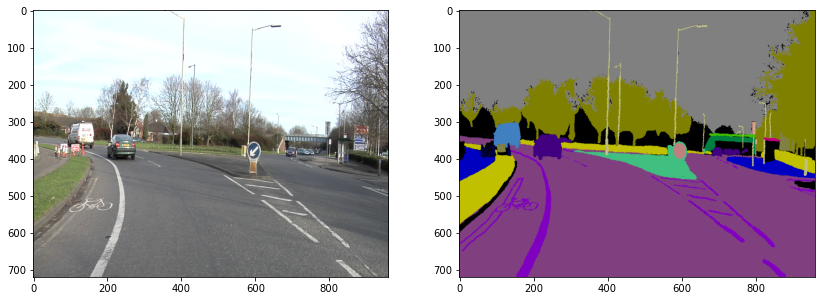

In [8]:
# show sample image
ex1 = Image.open('./data/train/train_images/0006R0_f00930.png')
ex2 = Image.open('./data/train/train_labels/0006R0_f00930_L.png')
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(ex1)
plt.subplot(122)
plt.imshow(ex2)
plt.show()

In [9]:
# load image data
def load_data(path, subset='train'):
    image_list, label_list = [], []
    image_files = glob(path+subset+'/'+subset+'_images/*.png')
    label_files = glob(path+subset+'/'+subset+'_labels/*.png')    
    for file in tqdm(image_files):
        img = Image.open(file)
        img = np.array(img)
        image_list.append(img)
    for file in tqdm(label_files):
        img = Image.open(file)
        img = np.array(img)
        label_list.append(img)
    return np.array(image_list), np.array(label_list)

path = './data/'
train_image, train_label = load_data(path, subset='train')
valid_image, valid_label = load_data(path, subset='valid')

  0%|          | 0/369 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
def image2mask(labels):
    semantic_map = []
    for color in tqdm(list(rgb_data.values())):
        equality = np.equal(labels, color)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return np.float32(semantic_map)

train_mask = image2mask(train_label)
valid_mask = image2mask(valid_label)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [11]:
# custom data set
class CamVidDataset(Dataset):
    def __init__(self, transforms_, subset='train'):
        self.transforms = transforms.Compose(transforms_)
        if subset=='train':
            self.images = train_image
            self.labels = train_mask
        elif subset=='valid':
            self.images = valid_image
            self.labels = valid_mask
        else:
            self.images = test_image
            self.labels = test_mask
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        images = self.images[idx]
        labels = self.labels[idx]
        return self.transforms(images), self.transforms(labels)

In [12]:
batch_size = 12
target_size = (224,224)

transforms_ = [
    transforms.ToTensor(),
    transforms.Resize(target_size),
]

train_loader = DataLoader(
    CamVidDataset(transforms_, subset='train'),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

valid_loader = DataLoader(
    CamVidDataset(transforms_, subset='valid'),
    batch_size=len(valid_image),
    shuffle=True,
    drop_last=True
)

## Build Model

In [13]:
# load pre-trained vgg16
vgg16 = models.vgg16(pretrained=True)

In [14]:
# define encoder block module using pre-trained vgg16
class EncoderBlock(nn.Module):
    def __init__(self, index):
        super(EncoderBlock, self).__init__()
        # build encoder sequential (Conv + BN + ReLU)
        self.block = nn.Sequential(
            vgg16.features[index],
            nn.BatchNorm2d(vgg16.features[index].out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.block(x)

In [15]:
# define encoder block module (Conv + BN + ReLU)
class DecoderBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(DecoderBlock, self).__init__()
        # build decoder sequential
        self.block = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.block(x)

In [16]:
class SegNet(nn.Module):
    def __init__(self, num_filters=64, in_dim=3, out_dim=num_classes):
        super(SegNet, self).__init__()
        # define convolution layer indices of vgg16 
        self.conv_index = [0,2,5,7,10,12,14,17,19,21,24,26,28]
        
        ### stage 1, 2 has 2 of Conv layer + Batch Norm layer + ReLU activation layer
        ### stage 3, 4, 5 has 3 of Conv layer + Batch Norm layer + ReLU activation layer
        
        ######################### ENCODER #########################
        # define max pooling layer
        self.MaxPooling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        # first encoding
        self.encoder1 = EncoderBlock(self.conv_index[0])
        self.encoder2 = EncoderBlock(self.conv_index[1])
        # second encoding
        self.encoder3 = EncoderBlock(self.conv_index[2])
        self.encoder4 = EncoderBlock(self.conv_index[3])
        # third encoding
        self.encoder5 = EncoderBlock(self.conv_index[4])
        self.encoder6 = EncoderBlock(self.conv_index[5])
        self.encoder7 = EncoderBlock(self.conv_index[6])
        # fourth encoding
        self.encoder8 = EncoderBlock(self.conv_index[7])
        self.encoder9 = EncoderBlock(self.conv_index[8])
        self.encoder10 = EncoderBlock(self.conv_index[9])
        # fifth encoding
        self.encoder11 = EncoderBlock(self.conv_index[10])
        self.encoder12 = EncoderBlock(self.conv_index[11])
        self.encoder13 = EncoderBlock(self.conv_index[12])
        
        ###########################################################
        ######################## SYMMETRIC ########################
        ###########################################################
        
        ######################### DECODER #########################
        # define max-pooling indices layer
        self.MaxUnPooling = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # first decoding
        self.decoder1 = DecoderBlock(num_filters*8, num_filters*8)
        self.decoder2 = DecoderBlock(num_filters*8, num_filters*8)
        self.decoder3 = DecoderBlock(num_filters*8, num_filters*8)
        # second decoding
        self.decoder4 = DecoderBlock(num_filters*8, num_filters*8)
        self.decoder5 = DecoderBlock(num_filters*8, num_filters*8)
        self.decoder6 = DecoderBlock(num_filters*8, num_filters*4)
        # third decoding
        self.decoder7 = DecoderBlock(num_filters*4, num_filters*4)
        self.decoder8 = DecoderBlock(num_filters*4, num_filters*4)
        self.decoder9 = DecoderBlock(num_filters*4, num_filters*2)
        # fourth decoding
        self.decoder10 = DecoderBlock(num_filters*2, num_filters*2)
        self.decoder11 = DecoderBlock(num_filters*2, num_filters)
        # fifth decoding
        self.decoder12 = DecoderBlock(num_filters, num_filters)
        self.decoder13 = DecoderBlock(num_filters, out_dim)
        # softmax classifier
        self.classifier = nn.Softmax()
        
    def forward(self, x):
        ######################### ENCODING #########################
        # stage 1
        size1 = x.size()
        x = self.encoder1(x)
        x = self.encoder2(x)
        x, idx1 = self.MaxPooling(x)
        # stage 2
        size2 = x.size()
        x = self.encoder3(x)
        x = self.encoder4(x)
        x, idx2 = self.MaxPooling(x)
        # stage 3
        size3 = x.size()
        x = self.encoder5(x)
        x = self.encoder6(x)
        x = self.encoder7(x)
        x, idx3 = self.MaxPooling(x)
        # stage 4
        size4 = x.size()
        x = self.encoder8(x)
        x = self.encoder9(x)
        x = self.encoder10(x)
        x, idx4 = self.MaxPooling(x)
        # stage 5
        size5 = x.size()
        x = self.encoder11(x)
        x = self.encoder12(x)
        x = self.encoder13(x)
        x, idx5 = self.MaxPooling(x)
        
        ######################### DECODING #########################
        # stage 5
        x = self.MaxUnPooling(x, idx5, output_size=size5)
        x = self.decoder1(x)
        x = self.decoder2(x)
        x = self.decoder3(x)
        # stage 4
        x = self.MaxUnPooling(x, idx4, output_size=size4)
        x = self.decoder4(x)
        x = self.decoder5(x)
        x = self.decoder6(x)
        # stage 3
        x = self.MaxUnPooling(x, idx3, output_size=size3)
        x = self.decoder7(x)
        x = self.decoder8(x)
        x = self.decoder9(x)
        # stage 2
        x = self.MaxUnPooling(x, idx2, output_size=size2)
        x = self.decoder10(x)
        x = self.decoder11(x)
        # stage 1
        x = self.MaxUnPooling(x, idx1, output_size=size1)
        x = self.decoder12(x)
        out = self.decoder13(x)
        # softmax activation function
        softmax_output = self.classifier(out)
        return out, softmax_output

In [17]:
model = SegNet().to(device)
summary(model, (3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
      EncoderBlock-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]          36,928
       BatchNorm2d-6         [-1, 64, 224, 224]             128
              ReLU-7         [-1, 64, 224, 224]               0
      EncoderBlock-8         [-1, 64, 224, 224]               0
         MaxPool2d-9  [[-1, 64, 112, 112], [-1, 64, 112, 112]]               0
           Conv2d-10        [-1, 128, 112, 112]          73,856
      BatchNorm2d-11        [-1, 128, 112, 112]             256
             ReLU-12        [-1, 128, 112, 112]               0
     EncoderBlock-13        [-1, 128, 112, 112]               0
           Conv2d-14    

# Set Loss function and Optimizer

In [18]:
# set learning rate scheduler to reduce loss
lr = 1e-3
loss_func = nn.CrossEntropyLoss().to(device)
optim = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = ReduceLROnPlateau(optim, 'min', patience=10, factor=0.5, verbose=True)
early_stopping = EarlyStopping(patience=30, verbose=True, path='./model/checkpoint.pt')

In [19]:
def train(model, 
          train_data, 
          validation_data,
          epochs,
          early_stop=False):
    
    loss_list, val_loss_list = [], []
    # train the model
    model.train()
    starting = time.time()
    for epoch in tqdm(range(epochs)):
        init_time = time.time()
        for images, labels in train_data:
            images, labels = images.to(device), labels.to(device)
            
            optim.zero_grad()
            
            output_images, _ = model(images)
            loss = loss_func(output_images, labels)
            
            loss.backward()
            optim.step()
        end_time = time.time()
        loss_list.append(loss.item())
        print(f'[Epoch {epoch+1}/{epochs}]  [Loss: {loss.item():.3f}]  [time: {end_time-init_time:.3f}s]')
        # validate the model
        with torch.no_grad():
            for val_images, val_labels in validation_data:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                
                val_outputs, _ = model(val_images)
                val_loss = loss_func(val_outputs, val_labels)
                lr_scheduler.step(val_loss)
                
            val_loss_list.append(val_loss.item())
            print(f'validation loss: {val_loss.item():.3f}')
        # set early stopping
        if early_stop:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print('##### Early Stopping #####')
                break
            
    ending = time.time()
    print(f'Total time for training is {ending-starting:.3f}s')
    return model, loss_list, val_loss_list

In [20]:
EPOCH = 300
model, train_loss, valid_loss = train(model, 
                                      train_loader, 
                                      validation_data=valid_loader,
                                      epochs=EPOCH,
                                      early_stop=True)

  0%|          | 0/300 [00:00<?, ?it/s]

[Epoch 1/300]  [Loss: 2.447]  [time: 15.808s]
validation loss: 2.481
Validation loss decreased (inf --> 2.481).  Saving model ...
[Epoch 2/300]  [Loss: 2.294]  [time: 11.858s]
validation loss: 2.262
Validation loss decreased (2.481 --> 2.262).  Saving model ...
[Epoch 3/300]  [Loss: 2.044]  [time: 11.816s]
validation loss: 2.041
Validation loss decreased (2.262 --> 2.041).  Saving model ...
[Epoch 4/300]  [Loss: 1.862]  [time: 12.000s]
validation loss: 1.879
Validation loss decreased (2.041 --> 1.879).  Saving model ...
[Epoch 5/300]  [Loss: 1.777]  [time: 12.086s]
validation loss: 1.761
Validation loss decreased (1.879 --> 1.761).  Saving model ...
[Epoch 6/300]  [Loss: 1.627]  [time: 12.227s]
validation loss: 1.658
Validation loss decreased (1.761 --> 1.658).  Saving model ...
[Epoch 7/300]  [Loss: 1.714]  [time: 12.560s]
validation loss: 1.642
Validation loss decreased (1.658 --> 1.642).  Saving model ...
[Epoch 8/300]  [Loss: 1.531]  [time: 11.820s]
validation loss: 1.563
Validatio

[Epoch 66/300]  [Loss: 0.289]  [time: 11.717s]
validation loss: 0.610
EarlyStopping counter: 2 out of 30
[Epoch 67/300]  [Loss: 0.348]  [time: 11.840s]
validation loss: 0.609
EarlyStopping counter: 3 out of 30
[Epoch 68/300]  [Loss: 0.272]  [time: 11.855s]
validation loss: 0.602
EarlyStopping counter: 4 out of 30
[Epoch 69/300]  [Loss: 0.261]  [time: 11.923s]
validation loss: 0.592
Validation loss decreased (0.595 --> 0.592).  Saving model ...
[Epoch 70/300]  [Loss: 0.244]  [time: 11.888s]
validation loss: 0.590
Validation loss decreased (0.592 --> 0.590).  Saving model ...
[Epoch 71/300]  [Loss: 0.211]  [time: 11.933s]
validation loss: 0.590
Validation loss decreased (0.590 --> 0.590).  Saving model ...
[Epoch 72/300]  [Loss: 0.224]  [time: 11.914s]
validation loss: 0.605
EarlyStopping counter: 1 out of 30
[Epoch 73/300]  [Loss: 0.244]  [time: 11.885s]
validation loss: 0.600
EarlyStopping counter: 2 out of 30
[Epoch 74/300]  [Loss: 0.230]  [time: 11.816s]
validation loss: 0.592
EarlyS

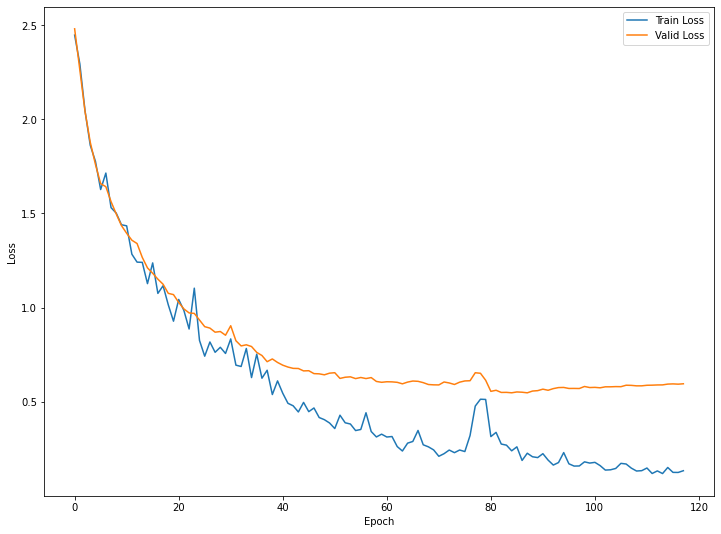

In [21]:
plt.figure(figsize=(12,9))
plt.plot(np.arange(len(train_loss)), train_loss, label='Train Loss')
plt.plot(np.arange(len(valid_loss)), valid_loss, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# Test

In [22]:
def image_resize(data_set, n_pixel=224):
    resized_list = []
    for img in data_set:
        img = cv2.resize(img, (n_pixel,n_pixel), cv2.INTER_AREA)
        resized_list.append(img)
    return np.array(resized_list)

In [23]:
# load test data
test_image, test_label = load_data(path, subset='test')
test_mask = image2mask(test_label)

test_image, test_label = image_resize(test_image), image_resize(test_label)

test_loader = DataLoader(
    CamVidDataset(transforms_, subset='test'),
    batch_size=len(test_image),
    drop_last=True,
    shuffle=False
)

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [25]:
# test
correct, total = 0, 0
output_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        # predict
        output, _ = model(images)
        output_list.append(output)

In [26]:
def map_class_to_rgb(p):
    return rgb_array[p[0]]

def mask2rgb(images):
    rgb_img_list = []
    for img in tqdm(images):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1,2,0))
        img = np.argmax(img, axis=-1)
        rgb_img = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(img, -1))
        rgb_img_list.append(rgb_img)
    return rgb_img_list

In [31]:
predict_test = mask2rgb(output_list[0])

  0%|          | 0/232 [00:00<?, ?it/s]

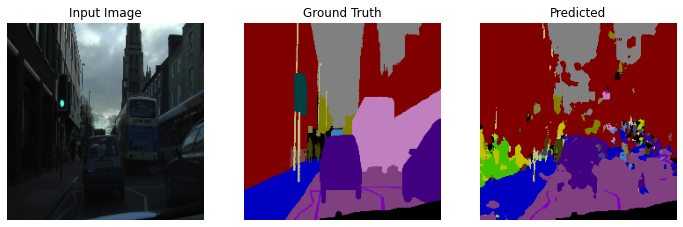

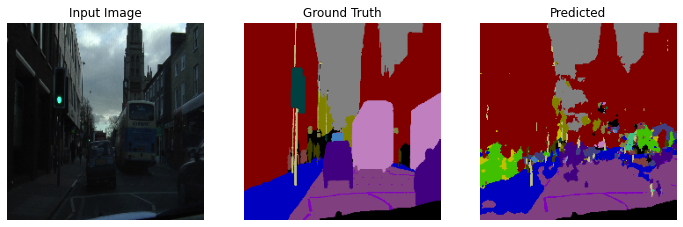

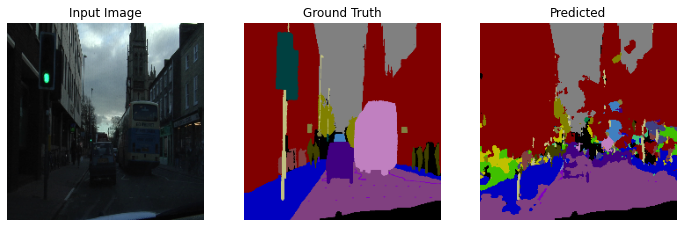

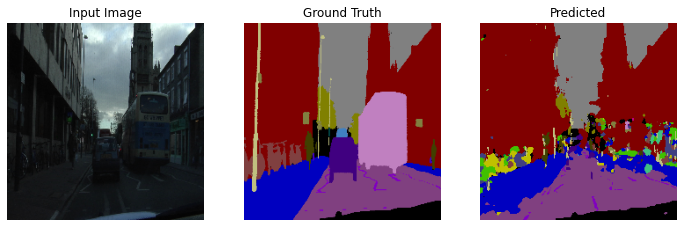

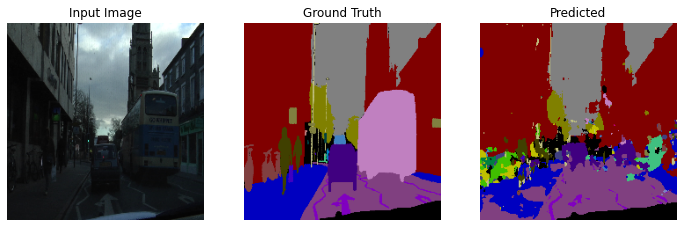

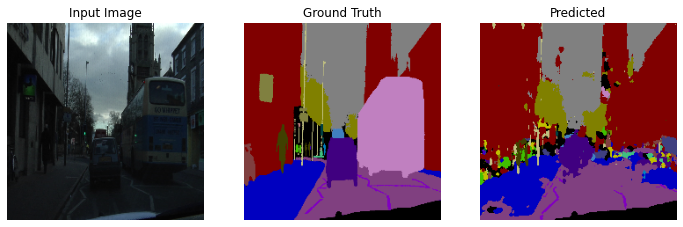

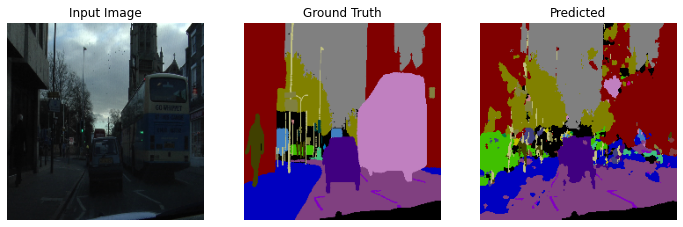

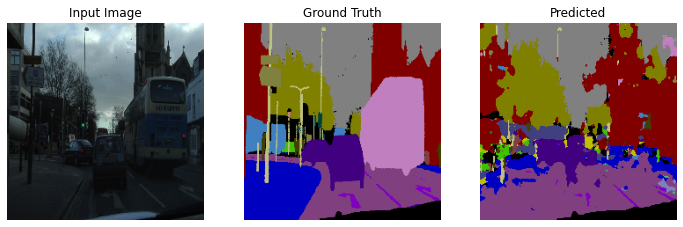

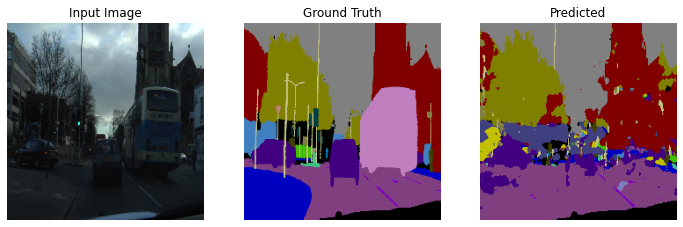

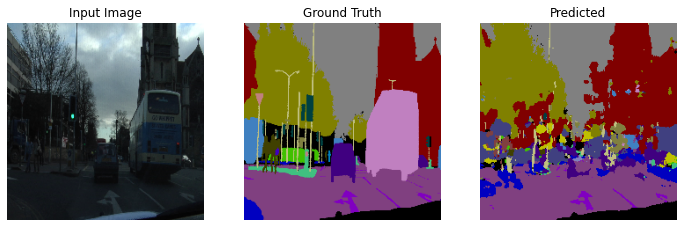

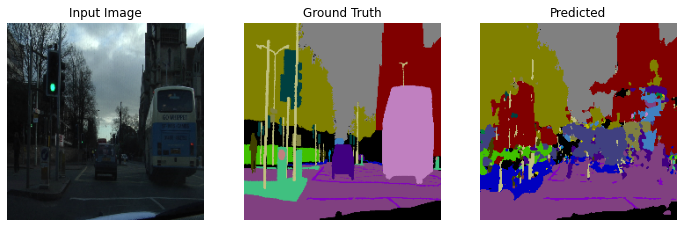

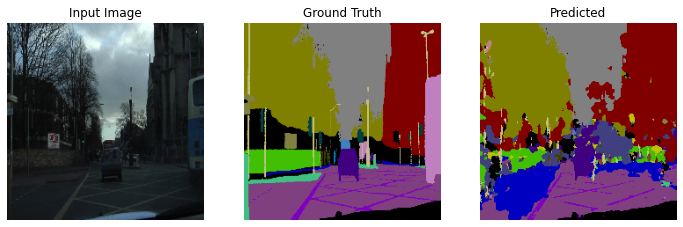

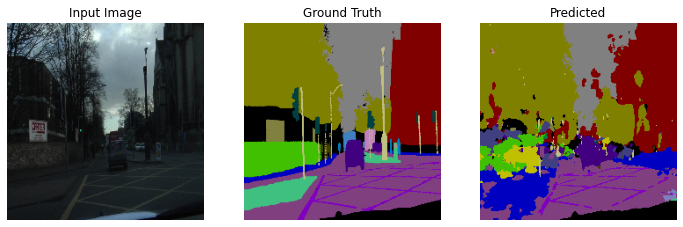

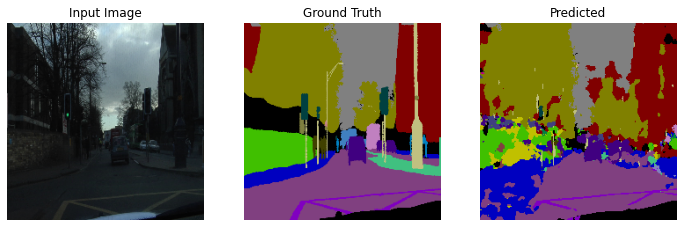

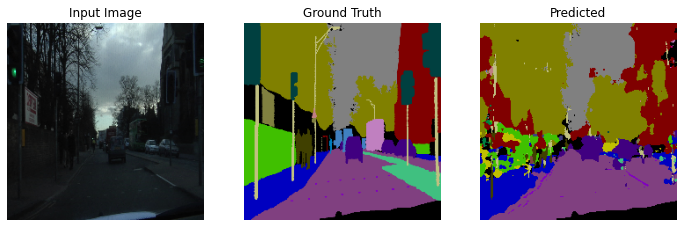

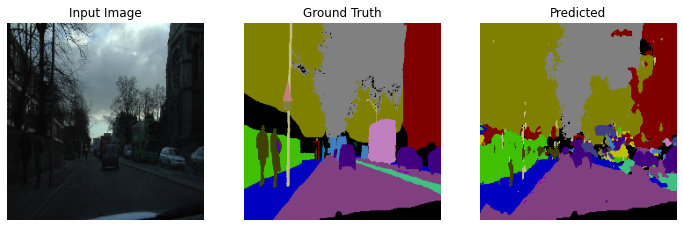

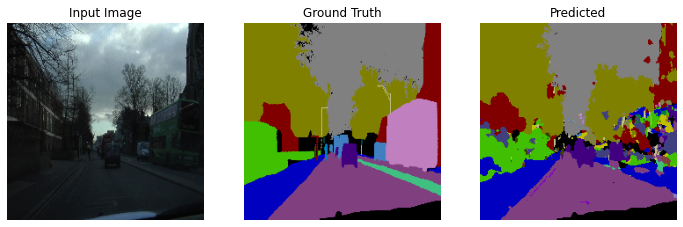

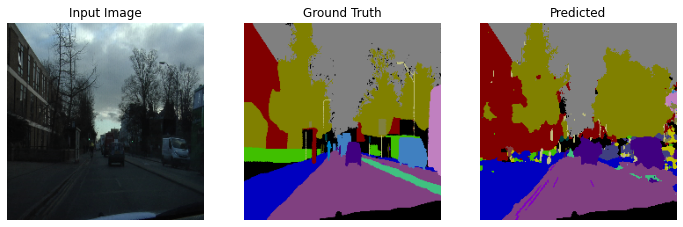

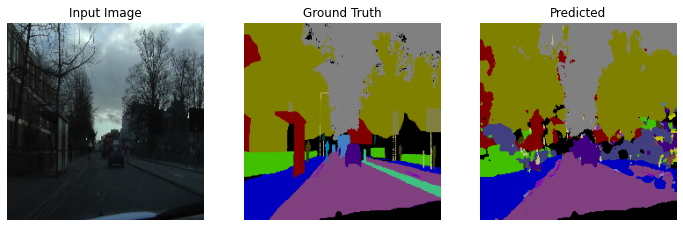

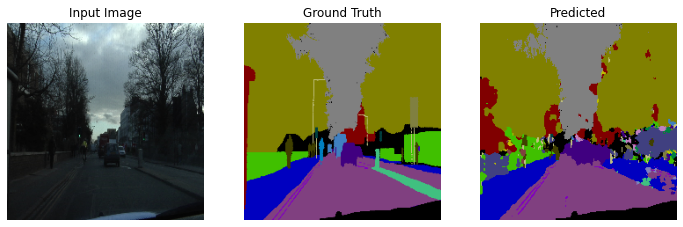

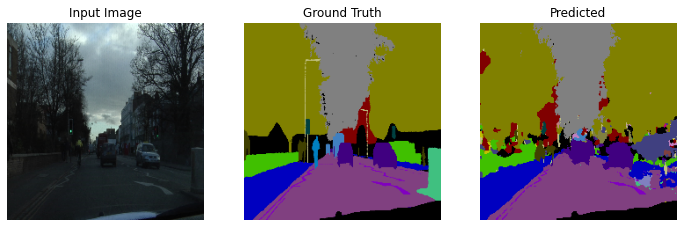

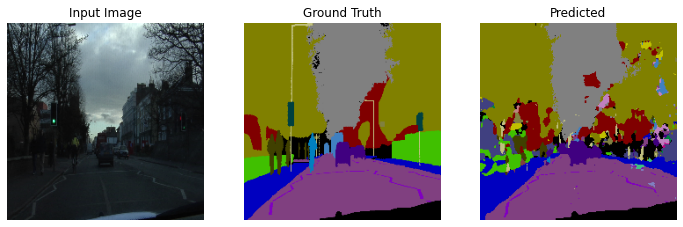

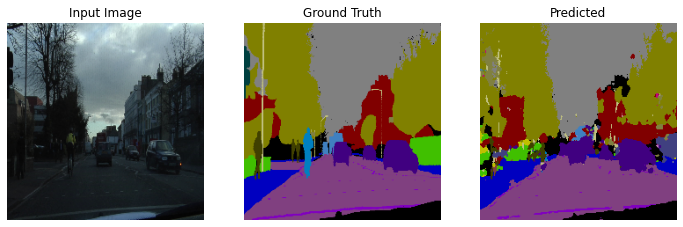

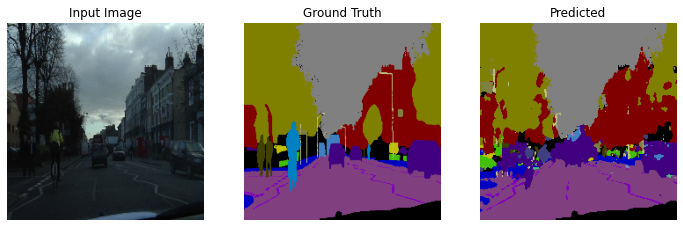

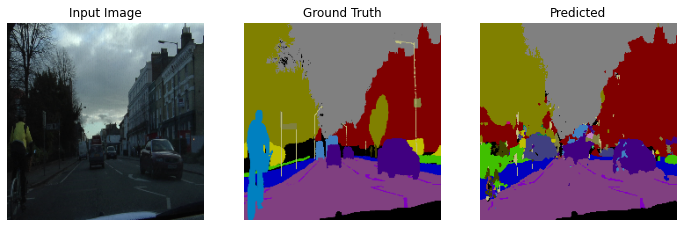

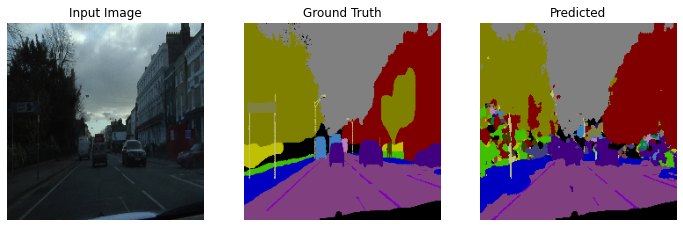

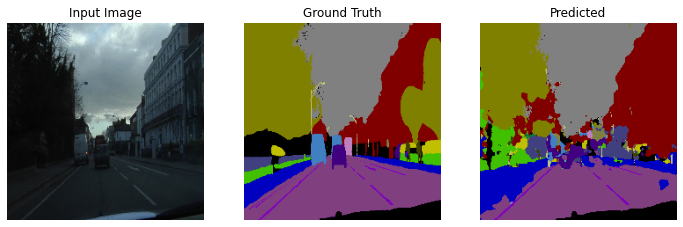

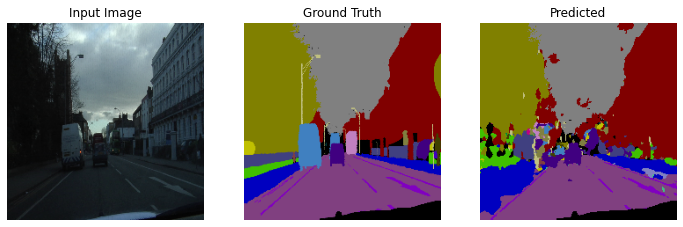

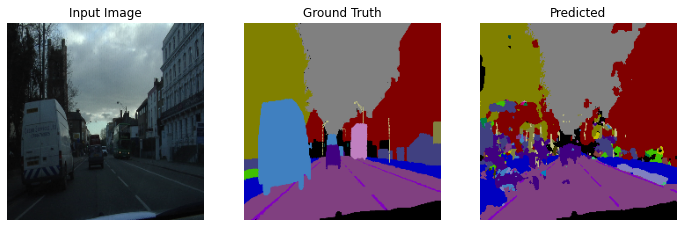

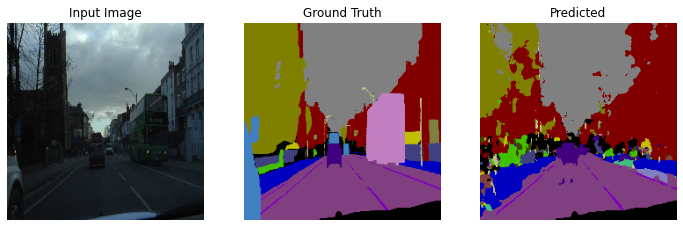

In [33]:
def show_result(image, label, result, ncols):
    for i in range(ncols):
        fig, ax = plt.subplots(1,3, figsize=(12,4))
        ax[0].imshow(image[i])
        ax[0].axis('off')
        ax[0].set_title('Input Image')
        ax[1].imshow(label[i])
        ax[1].axis('off')
        ax[1].set_title(f'Ground Truth')
        ax[2].imshow(result[i])
        ax[2].axis('off')
        ax[2].set_title(f'Predicted')
        fig.show()
        
show_result(test_image, test_label, predict_test, 30)